# Causal Embedding Pipeline: Batch Processing
Цей ноутбук запускає повний цикл експериментів для списку датасетів.
Він автоматично:
1. Завантажує графи
2. Генерує описи та ембедінги (або бере з кешу)
3. Будує матриці схожості
4. Проводить аналіз чутливості по `k` (Top-K Strategy)
5. Збирає агреговану статистику

In [6]:
import sys
import os

# Отримуємо абсолютний шлях до поточної папки
current_dir = os.getcwd()

# Отримуємо шлях до кореня проекту (піднімаємось на рівень вище)
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Додаємо корінь в sys.path, якщо його там ще немає
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"✅ Added to path: {project_root}")

In [7]:

%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.pipeline import CausalPipeline

datasets_to_run = [
    # --- MEDIUM (Core Benchmarks) ---
    # 'child',        # 20 nodes (Medicine: Congenital heart disease)
    #'insurance',    # 27 nodes (Business: Car insurance risk evaluation)
    #'water',        # 32 nodes (Ecology: Water treatment plant process)
    'mildew',       # 35 nodes (Agriculture: Wheat yield & fungicides)
    'alarm',        # 37 nodes (Medicine: Anesthesia monitoring system)
    'barley',       # 48 nodes (Agriculture: Barley yield & pesticides)

    # # --- LARGE (Stress Test & Efficiency Proof) ---
    # 'hailfinder',   # 56 nodes (Meteorology: Severe weather in Colorado)
    'hepar2',       # 70 nodes (Medicine: Liver disorders)
    'win95pts',     # 76 nodes (Tech: Windows 95 printer troubleshooting)

    # --- VERY LARGE (Stress Test / Scalability) ---
    'diabetes',     # 413 nodes (Medicine: Insulin metabolism)
    'link',         # 724 nodes (Genetics: Linkage analysis)

    # --- MASSIVE (Extreme Stress Test) ---
    'munin',     # 1041 nodes (Medicine: Electromyography - EXTREME)

    # These datasets cannot be used due to anonymized features:
    #'pathfinder',   # 109 nodes (Medicine: Lymph node diseases)
    #'andes',        # 223 nodes (Education: Physics tutoring system)
    #'pigs',         # 441 nodes (Agriculture: Pig breeding)
]

# ЗАПУСК (Це займе час залежно від кількості графів)
# Результат повернеться як великий DataFrame з усіма даними
pipeline = CausalPipeline()
df_all_results = pipeline.run_batch(datasets_to_run)


INFO:LLMService:LLMService initialized with model: gemini-3-flash-preview
INFO:EmbeddingService:Loaded 10 API keys for rotation.
INFO:EmbeddingService:Initialized active API key: ...bXw4
INFO:EmbeddingService:EmbeddingService initialized with model: models/gemini-embedding-001


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
🚀 Starting Batch Processing for 8 datasets...


Datasets:   0%|          | 0/8 [00:00<?, ?it/s]INFO:CausalPipeline:--- Processing mildew ---
INFO:LLMService:Enriching 35 nodes for dataset: mildew
INFO:LLMService:Loading cached node descriptions from c:\Users\user\Desktop\NAU\Дисертація\Проєкти\CausalEmbed\data\interim\nodes_mildew.json
INFO:EmbeddingService:Generating embeddings for 35 texts from dataset: mildew
INFO:EmbeddingService:Loading cached embeddings from c:\Users\user\Desktop\NAU\Дисертація\Проєкти\CausalEmbed\data\interim\embeddings_mildew.npy
INFO:EmbeddingService:All embeddings found in cache
INFO:GraphProcessor:Calculating cosine similarity matrix for 35 nodes
INFO:Evaluator:Evaluating UNDIRECTED: 25 predicted vs 46 ground truth pairs. Capacity: 595
INFO:Evaluator:Results - Recall: 0.2174, Precision: 0.4000, Reduction Rate: 0.9580
INFO:Evaluator:Evaluating UNDIRECTED: 155 predicted vs 46 ground truth pairs. Capacity: 595
INFO:Evaluator:Results - Recall: 0.6957, Precision: 0.2065, Reduction Rate: 0.7395
INFO:Evaluator:E

✅ Batch processing complete. Master log saved to c:\Users\user\Desktop\NAU\Дисертація\Проєкти\CausalEmbed\data\processed\batch_results_summary.csv


,dataset,n_nodes,density,optimal_k,achieved_recall,reduction_at_optimal
0,mildew,35,0.0387,13,0.869565,0.526050
1,alarm,37,0.0345,13,0.934783,0.557057
2,barley,48,0.0372,25,0.809524,0.336879
3,hepar2,70,0.0255,31,0.837398,0.430228
4,win95pts,76,0.0196,43,0.857143,0.320351
5,diabetes,413,0.0035,49,0.833887,0.855826
6,link,724,0.0021,97,0.803556,0.822696
7,munin,1041,0.0013,49,0.803865,0.937510


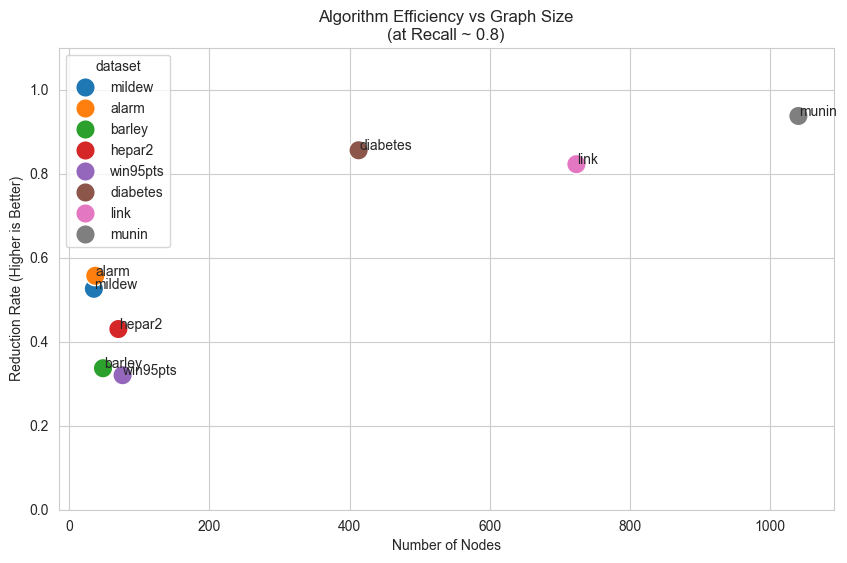

In [8]:

# 6. ГЛОБАЛЬНА АНАЛІТИКА: Ефективність від Розміру Графа
# Давайте візьмемо оптимальну точку для кожного графа.
# Наприклад, точку, де Recall перетинає TARGET_RECALL (або максимальний Recall, якщо < TARGET_RECALL)

TARGET_RECALL = 0.80
summary_stats = []

for name in df_all_results['dataset'].unique():
    subset = df_all_results[df_all_results['dataset'] == name]
    
    # Знаходимо мінімальне k, де Recall >= TARGET_RECALL
    high_recall_points = subset[subset['recall'] >= TARGET_RECALL]
    
    if not high_recall_points.empty:
        # Беремо "найдешевший" k (найменший), який дає високу якість
        optimal_point = high_recall_points.iloc[0]
    else:
        # Якщо ніколи не досягаємо TARGET_RECALL, беремо точку максимуму
        optimal_idx = subset['recall'].idxmax()
        optimal_point = subset.loc[optimal_idx]
        
    summary_stats.append({
        'dataset': name,
        'n_nodes': optimal_point['n_nodes'],
        'density': optimal_point['density'],
        'optimal_k': optimal_point['k'],
        'achieved_recall': optimal_point['recall'],
        'reduction_at_optimal': optimal_point['reduction_rate']
    })

df_summary = pd.DataFrame(summary_stats)
display(df_summary)

# 7. Графік: Як Reduction Rate залежить від кількості вузлів?
# (При умові збереження Recall ~ TARGET_RECALL)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_summary, x='n_nodes', y='reduction_at_optimal', s=200, hue='dataset')

# Додамо підписи
for i, row in df_summary.iterrows():
    plt.text(row['n_nodes']+1, row['reduction_at_optimal'], row['dataset'])

plt.title(f"Algorithm Efficiency vs Graph Size\n(at Recall ~ {TARGET_RECALL})")
plt.xlabel("Number of Nodes")
plt.ylabel("Reduction Rate (Higher is Better)")
plt.grid(True)
plt.ylim(0, 1.1)
plt.show()

📊 Results for Target Reduction Rate ≈ 40.0%:


,dataset,n_nodes,density,k_at_target,actual_rr,achieved_recall
0,mildew,35,0.039,19,0.343,0.978
1,alarm,37,0.034,19,0.377,1.000
2,barley,48,0.037,25,0.337,0.810
3,hepar2,70,0.026,31,0.430,0.837
4,win95pts,76,0.020,37,0.407,0.759
5,diabetes,413,0.004,193,0.391,0.998
6,link,724,0.002,349,0.400,0.980
7,munin,1041,0.001,493,0.399,0.991


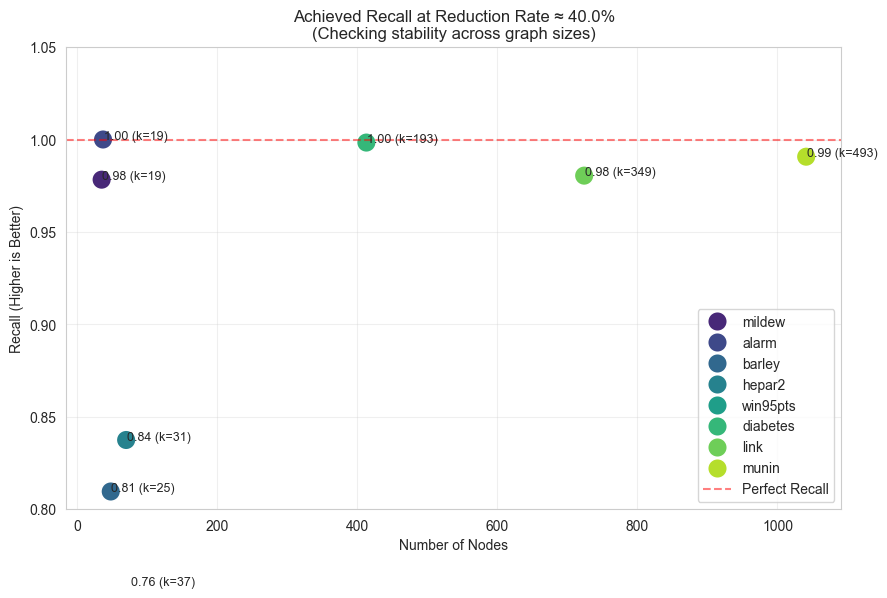

In [14]:
# 8. АНАЛІТИКА: Який Recall ми отримуємо при фіксованому Reduction Rate?
# Це дозволяє оцінити "гарантовану якість" при певному рівні стиснення.

# НАЛАШТУВАННЯ
# 0.10 = "Обережний фільтр" (відкидаємо 10% сміття, залишаємо 90%) -> Очікуємо Recall ~ 1.0
# 0.90 = "Агресивний фільтр" (відкидаємо 90% сміття, залишаємо 10%) -> Очікуємо падіння Recall
TARGET_RR = 0.40 

rr_stats = []

for name in df_all_results['dataset'].unique():
    subset = df_all_results[df_all_results['dataset'] == name].copy()
    
    # Оскільки точного значення 0.10 може не бути (через дискретність k),
    # ми шукаємо найближчу точку до цього значення.
    subset['diff'] = (subset['reduction_rate'] - TARGET_RR).abs()
    
    # Знаходимо індекс мінімальної різниці
    closest_idx = subset['diff'].idxmin()
    point = subset.loc[closest_idx]
    
    rr_stats.append({
        'dataset': name,
        'n_nodes': point['n_nodes'],
        'density': point['density'],
        'k_at_target': point['k'],
        'actual_rr': point['reduction_rate'], # Який RR вийшов по факту
        'achieved_recall': point['recall']    # Який Recall ми отримали
    })

df_rr_summary = pd.DataFrame(rr_stats)

print(f"📊 Results for Target Reduction Rate ≈ {TARGET_RR*100}%:")
display(df_rr_summary.round(3))

# 9. ГРАФІК: Recall vs Graph Size (при фіксованому Reduction Rate)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_rr_summary, 
    x='n_nodes', 
    y='achieved_recall',
    s=200, 
    hue='dataset',
    palette='viridis'
)

# Підписи
for i, row in df_rr_summary.iterrows():
    # Форматуємо підпис: "Recall (k=...)"
    label = f"{row['achieved_recall']:.2f} (k={int(row['k_at_target'])})"
    plt.text(row['n_nodes']+1, row['achieved_recall'], label, fontsize=9)

plt.title(f"Achieved Recall at Reduction Rate ≈ {TARGET_RR*100}%\n(Checking stability across graph sizes)")
plt.xlabel("Number of Nodes")
plt.ylabel("Recall (Higher is Better)")
plt.ylim(0.8, 1.05) # Recall завжди від 0 до 1
plt.grid(True, alpha=0.3)

# Додамо лінію ідеального Recall
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Perfect Recall')
plt.legend()

plt.show()

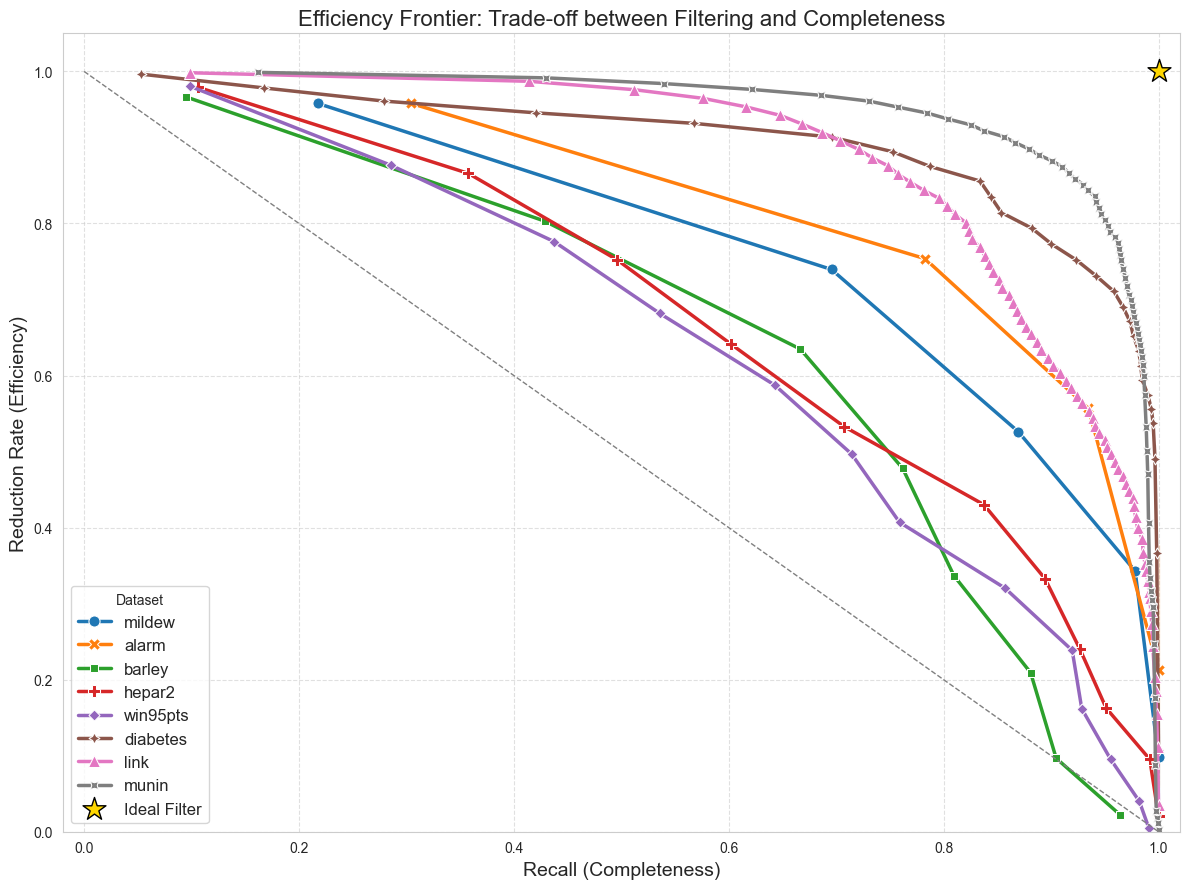

In [11]:
# %%
# 8. Efficiency Frontier: Reduction Rate vs Recall
# Це найважливіший графік для порівняння якості на різних датасетах.

plt.figure(figsize=(12, 9))

# Малюємо лінії
sns.lineplot(
    data=df_all_results, 
    x='recall', 
    y='reduction_rate', 
    hue='dataset', 
    style='dataset',    # Різні стилі ліній для доступності
    markers=True,       # Маркери показують кроки k
    dashes=False,       # Суцільні лінії
    markersize=8,
    linewidth=2.5
)

# Додаємо "Ідеальну точку" (1.0, 1.0) для орієнтиру
plt.scatter([1], [1], color='gold', s=300, marker='*', label='Ideal Filter', zorder=10, edgecolors='black')

# Налаштування осей
plt.title("Efficiency Frontier: Trade-off between Filtering and Completeness", fontsize=16)
plt.xlabel("Recall (Completeness)", fontsize=14)
plt.ylabel("Reduction Rate (Efficiency)", fontsize=14)

# Сітка та межі
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(-0.02, 1.02) # Фокусуємось на правій частині (низький Recall нам не цікавий)
plt.ylim(0, 1.05)
plt.legend(title="Dataset", fontsize=12, loc='lower left')

# Додати підписи значень k на графік
# for dataset in df_all_results['dataset'].unique():
#     subset = df_all_results[df_all_results['dataset'] == dataset]
#     for _, row in subset.iterrows():
#         plt.text(row['recall'], row['reduction_rate'], f"{row['k']}", fontsize=9, alpha=0.7)

plt.plot(
    [0, 1], [1, 0], 
    color='gray', 
    linestyle='--', 
    linewidth=1, 
    label='Random Guessing (Baseline)'
)

plt.tight_layout()
plt.show()